# Machine learning with raw frequencies

In [48]:
import pickle
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn import naive_bayes, metrics
from itertools import chain
from math import log
from nltk import BigramAssocMeasures


with open('test_dicts.txt', 'rb') as file:
    test_lemmedreviews = pickle.load(file)
    
with open('training_dicts.txt', 'rb') as file:
    train_lemmedreviews = pickle.load(file)

In [49]:
candidate_features = Counter()

for p in range(1, 6):
    for rev in train_lemmedreviews[p]:
        for w in rev:
            if w.split("-")[-1] in ["ADJ", "ADV", "NEGATION"]:
                candidate_features[w] += 1


print("candidate features:", len(candidate_features))

candidate features: 1548


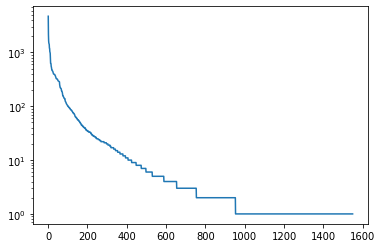

In [50]:
x = np.arange(1, len(candidate_features) + 1)
y = np.array([v for _, v in candidate_features.most_common()])

plt.plot(x, y)
plt.yscale('log') 
plt.show()

In [51]:
features = dict()

for idx, (f, v) in enumerate(candidate_features.most_common()):
    if v == 9:
    #    print(idx, f, v)
        break

    features[f] = idx
    
print("selected features:", len(features))

selected features: 424


## Normal weighting

In [52]:
fMat = np.zeros((sum([len(v) for v in train_lemmedreviews.values()]), len(features)))
labelsVec = np.zeros((sum([len(v) for v in train_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in train_lemmedreviews[score]:
        labelsVec[docId] = score
        
        for word in rev:
            if word in features:
                fMat[docId, features[word]] += 1

        docId += 1
        
print(fMat, labelsVec)

[[2. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [2. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 5. 5. 5.]


In [53]:
clf = naive_bayes.MultinomialNB()
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
testMat = np.zeros((sum([len(v) for v in test_lemmedreviews.values()]), len(features)))
goldStandard = np.zeros((sum([len(v) for v in test_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in test_lemmedreviews[score]:
        goldStandard[docId] = score

        for word in rev:
            if word in features:
                testMat[docId, features[word]] += 1

        docId += 1

In [55]:
predicted = clf.predict(testMat)

In [56]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard, average='macro'))
print("recall:", metrics.recall_score(predicted, goldStandard, average='macro'))
print("f1-measure:", metrics.f1_score(predicted, goldStandard, average='macro'))

accuracy: 0.6753333333333333
precision: 0.39878897168535293
recall: 0.4949316983503316
f1-measure: 0.42220188839529404


## Machine learning with tfidf weighting

In [57]:
fMat = np.zeros((sum([len(v) for v in train_lemmedreviews.values()]), len(features)))
labelsVec = np.zeros((sum([len(v) for v in train_lemmedreviews.values()])))


docId = 0
for score in range(1, 6):
    for rev in train_lemmedreviews[score]:
        labelsVec[docId] = score
        
        for word in rev:
            if word in features:
                fMat[docId, features[word]] += 1

        docId += 1
        

D=(sum([len(v) for v in train_lemmedreviews.values()]))
for column in range(len(features)): 
    Dt = len(np.where(fMat[:,column] > 0)[0])   
    if Dt > 0: 
        testMat[:, column] = testMat[:, column] * np.log(D/Dt)   
    fMat[:, column] = fMat[:, column] * np.log(D/Dt)

    
print(fMat, labelsVec)

[[2.00510745 0.         0.         ... 0.         0.         0.        ]
 [2.00510745 0.         0.         ... 0.         0.         0.        ]
 [2.00510745 0.         1.77750856 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] [1. 1. 1. ... 5. 5. 5.]


In [58]:
clf = naive_bayes.MultinomialNB()
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
testMat = np.zeros((sum([len(v) for v in test_lemmedreviews.values()]), len(features)))
goldStandard = np.zeros((sum([len(v) for v in test_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in test_lemmedreviews[score]:
        goldStandard[docId] = score

        for word in rev:
            if word in features:
                testMat[docId, features[word]] += 1

        docId += 1
        
D=sum([len(v) for v in test_lemmedreviews.values()])
for column in range(len(features)): 
    Dt = len(np.where(testMat[:,column] > 0)[0])
    if Dt > 0: 
        testMat[:, column] = testMat[:, column] * np.log(D/Dt)

In [60]:
predicted = clf.predict(testMat)

In [61]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard, average='macro'))
print("recall:", metrics.recall_score(predicted, goldStandard, average='macro'))
print("f1-measure:", metrics.f1_score(predicted, goldStandard, average='macro'))

accuracy: 0.6006666666666667
precision: 0.46437162799505893
recall: 0.4271215221094808
f1-measure: 0.4403294251495263


# Machine Learning with co-occurences

In [62]:
span = 3
cooccs_candidate_feature = Counter()


for p in range(1, 6):
    for sentence in train_lemmedreviews[p]:
        for i,w in enumerate(sentence):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(sentence)))) 
            for cw in [sentence[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_candidate_feature:
                    cooccs_candidate_feature[(w, cw)] += 1


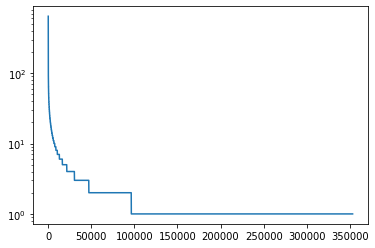

In [63]:
x = np.arange(1, len(cooccs_candidate_feature) + 1)
y = np.array([v for _, v in cooccs_candidate_feature.most_common()])

plt.plot(x, y)
plt.yscale('log') 
plt.show()

In [64]:
cooccs_features = dict()

for idx, (f, v) in enumerate(cooccs_candidate_feature.most_common()):
    if v == 9:
    #    print(idx, f, v)
        break

    cooccs_features[f] = idx
    
print("selected features:", len(cooccs_features))

selected features: 7497


In [65]:
fMat = np.zeros((sum([len(v) for v in train_lemmedreviews.values()]), len(cooccs_features)))
labelsVec = np.zeros((sum([len(v) for v in train_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in train_lemmedreviews[score]:
        labelsVec[docId] = score
        
        span = 3
        cooccs_rev = Counter()

        for i,w in enumerate(rev):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(rev)))) 
            for cw in [rev[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_rev:
                    cooccs_rev[(w, cw)] += 1
        
        
        for cooccs in list(cooccs_rev.keys()):
            if cooccs in cooccs_features:
                fMat[docId, cooccs_features[cooccs]] += cooccs_rev[cooccs]

        docId += 1
        
print(fMat, labelsVec)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 5. 5. 5.]


In [66]:
clf = naive_bayes.MultinomialNB()
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
testMat = np.zeros((sum([len(v) for v in test_lemmedreviews.values()]), len(cooccs_features)))
goldStandard = np.zeros((sum([len(v) for v in test_lemmedreviews.values()])))

docId = 0
for score in range(1, 6):
    for rev in test_lemmedreviews[score]:
        goldStandard[docId] = score
        
        span = 3
        cooccs_rev = Counter()

        for i,w in enumerate(rev):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(rev)))) 
            for cw in [rev[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_rev:
                    cooccs_rev[(w, cw)] += 1
        
        
        for cooccs in list(cooccs_rev.keys()):
            if cooccs in cooccs_features:
                testMat[docId, cooccs_features[cooccs]] += cooccs_rev[cooccs]

        docId += 1
        
print(testMat, goldStandard)

[[0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 5. 5. 5.]


In [68]:
predicted = clf.predict(testMat)

In [69]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard, average='macro'))
print("recall:", metrics.recall_score(predicted, goldStandard, average='macro'))
print("f1-measure:", metrics.f1_score(predicted, goldStandard, average='macro'))

accuracy: 0.8366666666666667
precision: 0.7467949892701389
recall: 0.7839628825277897
f1-measure: 0.7640657539098037


## Machine Learning with plmi weighted co-occurences

In [108]:
def ppmi(o_11, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    PMI is also available in NLTK:
    from nltk.metrics import BigramAssocMeasures
    print BigramAssocMeasures.pmi(8, (15828, 4675), 14307668)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

def plmi(o_11, r_1, c_1, n):
    """
    Positive Local Mutual Information, useful for leveraging the 
    low-frequency bias of the PPMI
    """
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res

In [151]:
N = len(cooccs_candidate_feature.values())
plmis_lem_surface = Counter()
#print(test_lemmedreviews.values())
print(len(list(train_lemmedreviews.values())))

lem_frequencies = []
for k in range(1,6):
    lem_frequencies.append(train_lemmedreviews[k])
    
lem_frequencies = Counter(chain(*lem_frequencies))



#for k,v in cooccs_candidate_feature.items():
#    plmis_lem_surface[k] = plmi(v, lem_frequencies[k[0]], lem_frequencies[k[1]], N)

print(plmis_lem_surface.most_common(10))

5


TypeError: unhashable type: 'list'